<h1><center>P7 - CREATE & IMPLEMENT A CREDIT SCORING MODEL</center></h1>

<div style="width:100%;text-align: center;"> <img align=middle src="http://www.financialbuzz.co.uk/wp-content/uploads/2012/04/Loans-For-Bad-Credit.jpg" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>

### OVERVIEW

We are a Data Scientist within the financial institution "Prêt à dépenser" which give loans to people with insufficient or non-existent credit history.

The company wishes to implement a credit scoring model in order to make good decisions.
Two types of risks are associated with the bank’s decision:

a. If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

b. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.

In addition, customers service are pushed more and more by clients to explain their decision to grant a loan and it's in this mindset that "Prêt à dépenser" wants to move forward.

"Prêt à dépenser" has then decided to develop an interactive dashboard so that not only their customers service team can explain - in the most transparent way - their decisions to give or not the loans to their clients but also to give full access to their own information. 

### DATA

The dataset provided contains a vast number of details about the borrower. It is separated into several relational tables, which contain applicants’ static data such as their gender, age, number of family members, occupation, and other necessary fields, applicant’s previous credit history obtained from the credit bureau department, and the applicant’s past credit history.<br>
Data can be found here:<br> https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip


### OBJECTIVE

* Create & implement a credit scoring model which will return automatically a probability for a client to default his loan.
* Create an interactive dashboard to later provide to the customers service management team so that they can interpret the model's predictions. It will provide them valuable information in order to improve their knowledge of the clients and to train their staff.

In order to mainly focus on the creation, implementation and optimization of our model, Michaël, our manager, encouraged us to carefully choose an existing Kaggle kernel to ease the pre-processing work on this dataset.<br>
We decided to opt for the kernel of student Rishabh Rao who did an exhaustive data pre-processing work.

## PART 3 - Modeling

## Table of Contents

* [1. Dataset Importation](#chapter1)
    * [1.1 Full model](#section_1_1)
    * [1.2 Selected Features model (via BorutaPy)](#section_1_2)
* [2. Models comparison](#chapter2)
    * [2.1 Overview](#section_2_1)
    * [2.2 LightGBM](#section_2_2)
    * [2.3 XGBoost](#section_2_3)
    * [2.4 CatBoost](#section_2_4)
* [3. Impact of Synthetic Minority Oversampling Technique (SMOTE)](#chapter3)
* [4. OPTNUA Hyperparameters Optimization](#chapter4)
    * [4.1 LightGBM - Ltd model](#section_4_1)
    * [4.2 LightGBM - Class weight = balanced - Ltd model](#section_4_2)
    * [4.3 LightGBM - SMOTE - Ltd model](#section_4_3)
    * [4.4 LightGBM - Eval metrics = cost function](#section_4_4)
    * [4.5 LightGBM - Class weight = balanced - Eval metrics = cost function](#section_4_5)
    * [4.6 LightGBM - SMOTE - Eval metrics = cost function](#section_4_6)
    * [4.7 LightGBM - Eval metrics = cost function1](#section_4_7)
    * [4.8 LightGBM - Class weight = balanced - eval metrics = cost function1](#section_4_8)
    * [4.9 LightGBM - SMOTE - Eval metrics = cost function1](#section_4_9)
* [5. Solvency threshold determination](#chapter5)
* [6. Features importance via SHAP (SHapley Additive exPlanations)](#chapter6)

In [1]:
# ! usr/bin/env python 3
# coding: utf-8

import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import pickle
import joblib as joblib
from collections import Counter
import warnings

# Vizualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    PowerTransformer, RobustScaler
# Oversampling
from imblearn.over_sampling import SMOTE

# Modeling
# Pre-processing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, \
                             GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Ptuna hyperparameters Optimisatio
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import LightGBMPruningCallback

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, \
                            recall_score, precision_score, matthews_corrcoef, \
                            cohen_kappa_score, fbeta_score, make_scorer, \
                            average_precision_score, log_loss, confusion_matrix, \
                            classification_report
# Features Interpretation
import shap

# Warnings

from warnings import simplefilter
simplefilter("ignore", category=Warning)
warnings.filterwarnings('ignore')
    
from IPython.core.display import display, HTML

from func_modp7 import*

%matplotlib inline
%load_ext autoreload
%autoreload 2

All functions run in this notebook can be found at: functions_P7_feat.py

In [2]:
start_time = datetime.now()

## 1. Dataset importation<a class="anchor" id="chapter1"></a>

### 1.1 Full model<a class="anchor" id="section_1_1"></a>

In [3]:
# Load data - full range
data_train = pd.read_pickle("train_data.pkl")
data_test = pd.read_pickle("test_data.pkl")
print("Data train shape is:", data_train.shape)
print("Data test shape is:", data_test.shape)

Data train shape is: (307506, 633)
Data test shape is: (48744, 632)


In [4]:
# Target y 
y = data_train['TARGET']
# Dataset copytrain 
train_set= data_train.copy()
test_set = data_test.copy()
X_test = test_set
# Customer Id as index for modeling
train_set.set_index('SK_ID_CURR', inplace=True)
# Target drop for modeling
X = train_set.drop(['TARGET'], axis=1)
# X = test_set
print(f'X : {X.shape}')
print(f'y : {y.shape}')

X : (307506, 631)
y : (307506,)


### 1.1 Selected features model (via BorutaPy)<a class="anchor" id="section_1_2"></a>

In [5]:
# Load data - Lighter range after Boruta
data_train_boruta = pd.read_pickle("train_data_boruta.pkl")
data_test_boruta = pd.read_pickle("test_data_boruta.pkl")
print("Data train shape is:", data_train_boruta.shape)
print("Data test shape is:", data_test_boruta.shape)

Data train shape is: (307506, 88)
Data test shape is: (48744, 87)


In [6]:
# Target y 
train_set_boruta= data_train_boruta.copy()
y_boruta = train_set_boruta['TARGET']
# Dataset copytrain 
test_set_boruta = data_test_boruta.copy()
X_test_boruta = test_set_boruta
# Customer Id as index for modeling
train_set_boruta.set_index('SK_ID_CURR', inplace=True)
# Target drop for modeling
X_boruta = train_set_boruta.drop(['TARGET'], axis=1)
print(f'X_boruta : {X_boruta.shape}')
print(f'y_boruta : {y_boruta.shape}')

X_boruta : (307506, 86)
y_boruta : (307506,)


#### Train/test split on full train dataset

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=42)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (215254, 631) - y_train : (215254,)
X_valid : (92252, 631) - y_valid : (92252,)


#### Train/test split on train dataset after features selection

In [8]:
X_train_boruta, X_valid_boruta, y_train_boruta, y_valid_boruta = train_test_split(X_boruta, y_boruta,
                                                      test_size=0.3,
                                                      shuffle=True,
                                                      stratify=y_boruta,
                                                      random_state=42)
print(f'X_train_boruta : {X_train_boruta.shape} - y_train_boruta : {y_train_boruta.shape}')
print(f'X_valid_boruta : {X_valid_boruta.shape} - y_valid_boruta : {y_valid_boruta.shape}')

X_train_boruta : (215254, 86) - y_train_boruta : (215254,)
X_valid_boruta : (92252, 86) - y_valid_boruta : (92252,)


## 2. Models comparison - Base parameters<a class="anchor" id="chapter2"></a>

### 2.1 Overview<a class="anchor" id="section_2_1"></a>

We decided to investigate different models with their default parameters to get an overview of their performance.

In [9]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(), # long run time
          KNeighborsClassifier(), # long run time
          CatBoostClassifier(logging_level='Silent'), 
          LGBMClassifier(), 
          XGBClassifier(eval_metric='mlogloss')] 

Few metrics were chosen to evaluate each model's performance:<br>

__1. AUC__<br>
AUC is the area under the ROC curve. AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes

__2. Accuracy__<br>
Accuracy is the proportion of true results among the total number of cases examined.
Accuracy = (TP+TN)/(TP+FP+FN+TN)

__3. Precision__<br>
Precision indicates the proportion of predicted Positives that is truly Positive
Precision = (TP)/(TP+FP)
Being very precise means our model will leave a lot of credit defaulters untouched and hence lose money.

__4. Recall__<br>
Recall indicates the proportion of actual Positives that is correctly classified.
Recall = (TP)/(TP+FN)

__5. F1 Score__<br>
The F1 score is a number between 0 and 1 and is the harmonic mean of precision and recall.

#### Full model

In [10]:
# start=datetime.now()
# name, auc, accuracy, precision = [], [], [], []
# recall, f1, time_ = [], [], []

# for model in models:
#     start_time = datetime.now()
#     results = train_models(model, X_train, X_valid, y_train, y_valid)

#     name.append(type(model).__name__)
#     auc.append(results['AUC'])
#     accuracy.append(results['Accuracy'])
#     precision.append(results['Precision'])
#     recall.append(results['Recall'])
#     f1.append(results['F1'])
#     time_.append(datetime.now() - start_time)

# #Initialise data of lists
# base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
# base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
# base_models.sort_values('AUC', ascending=False, inplace=True)
# elapsed=datetime.now()-start
# print(f'Running Time of models comparison: {elapsed}')
# base_models.to_pickle('base_models.pkl')
# base_models

In [11]:
base_models = pd.read_pickle("base_models.pkl")
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
7,CatBoostClassifier,0.790446,0.920078,0.549865,0.054787,0.099646,0 days 00:04:05.757804
8,LGBMClassifier,0.786118,0.91998,0.555938,0.043373,0.080468,0 days 00:00:35.827158
5,GradientBoostingClassifier,0.776776,0.919882,0.576087,0.028468,0.054255,0 days 00:27:29.440783
9,XGBClassifier,0.776058,0.918625,0.472924,0.070364,0.122501,0 days 00:02:37.176707
4,AdaBoostClassifier,0.767032,0.919449,0.512579,0.043776,0.080663,0 days 00:06:37.112626
3,ExtraTreesClassifier,0.743568,0.919341,0.625,0.002014,0.004016,0 days 00:05:01.013198
2,RandomForestClassifier,0.735487,0.919492,0.647059,0.005908,0.01171,0 days 00:10:32.855064
0,LogisticRegression,0.588228,0.919254,0.0,0.0,0.0,0 days 00:00:38.104040
1,DecisionTreeClassifier,0.549952,0.855949,0.16027,0.185041,0.171767,0 days 00:05:51.176571
6,KNeighborsClassifier,0.533855,0.913845,0.131075,0.011951,0.021905,0 days 02:11:44.583828


On the full model (731 features) and based on the AUC metric, our first 4 models are CatBoost, LGBM, GradientBoosting and XGB. While AuC metrics are quite close to each other, the factor Run Time is a good indication of how fast the algorithms run. GradientBoosting run in 27 min while LGBM run in 33 seconds.

#### Features selected model

In [12]:
# start=datetime.now()
# name, auc, accuracy, precision = [], [], [], []
# recall, f1, time_ = [], [], []

# for model in models:
#     start_time = datetime.now()
#     results = train_models(model, X_train_boruta, X_valid_boruta, y_train_boruta, y_valid_boruta)

#     name.append(type(model).__name__)
#     auc.append(results['AUC'])
#     accuracy.append(results['Accuracy'])
#     precision.append(results['Precision'])
#     recall.append(results['Recall'])
#     f1.append(results['F1'])
#     time_.append(datetime.now() - start_time)

# #Initialise data of lists
# base_models_boruta = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
# base_models_boruta.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
# base_models_boruta.sort_values('AUC', ascending=False, inplace=True)
# elapsed=datetime.now()-start
# print(f'Running Time of models comparison: {elapsed}')
# base_models_boruta.to_pickle('base_models_boruta.pkl')
# base_models_boruta

In [13]:
base_models_boruta = pd.read_pickle("base_models_boruta.pkl")
base_models_boruta

,Model,AUC,Accuracy,Precision,Recall,F1,Time
7,CatBoostClassifier,0.782161,0.919926,0.550167,0.044179,0.08179,0 days 00:00:59.383759
8,LGBMClassifier,0.77715,0.919742,0.55643,0.028468,0.054165,0 days 00:00:05.177648
9,XGBClassifier,0.769478,0.919015,0.485577,0.05425,0.097596,0 days 00:00:18.840562
5,GradientBoostingClassifier,0.766821,0.919536,0.559406,0.015174,0.029546,0 days 00:04:18.633059
4,AdaBoostClassifier,0.757043,0.919145,0.483784,0.024037,0.045798,0 days 00:01:02.184272
3,ExtraTreesClassifier,0.741532,0.919406,0.642857,0.003626,0.007211,0 days 00:01:41.693442
2,RandomForestClassifier,0.732764,0.91946,0.613333,0.006177,0.012231,0 days 00:03:10.174133
0,LogisticRegression,0.636312,0.919178,0.235294,0.000537,0.001072,0 days 00:00:06.797151
1,DecisionTreeClassifier,0.54356,0.852979,0.149151,0.174567,0.160861,0 days 00:00:31.228527
6,KNeighborsClassifier,0.539797,0.914018,0.128637,0.01128,0.020741,0 days 00:30:45.067437


On the model Ltd (subject to BorutaPy features selection - 87 features), run time are much smaller as expected and AUC score slightly too. Again GradientBoosting running time is much longer and is not practical for our future hyperparameters optimization.

Let's focus on the first 3 best models for the following: CatBoost, LGBM & XGB

In [14]:
models_select = [CatBoostClassifier(logging_level='Silent'), 
                 LGBMClassifier(), 
                 XGBClassifier(eval_metric='mlogloss')] 

In addition to the metrics proposed above, a confusion matrix will be created for each algorithm and each dataset (full dataset or features selected dataset).<br>
A Confusion Matrix contains the counts of our predicted data divided in 4 parts with respect to original data.<br>
Each part will correspond to a category of customers:

__TN: True Negative:__ (good Prediction): We estimated customer as not defaulter and the actual figures register customer as not defaulted (no differences between predicted and actual default).

__FN: False Negative:__ or Type II Error (bad Prediction): We estimated customer as not defaulter but, defaults

__TP: True Positive:__ (good Prediction): We predicted customer as defaulter and indeed customer defaulted

__FP: False Positive__ or Type I Error (bad prediction): We predicted applicant as defaulter customer, but the customer actually didn’t default.

The bank objective will obviously be to reduce bad predictions as much as possible.<br>

If the bank grant a loan to someone who cannot pay it back (FN), it will lose big money.<br>
If the bank does not grant a loan to someone who can pay it back, it will lose a potential customer and the interests related to this loan

In [15]:
df_res = pd.DataFrame({})

### 2.2 LightGBM<a class="anchor" id="section_2_2"></a>

#### Full dataset

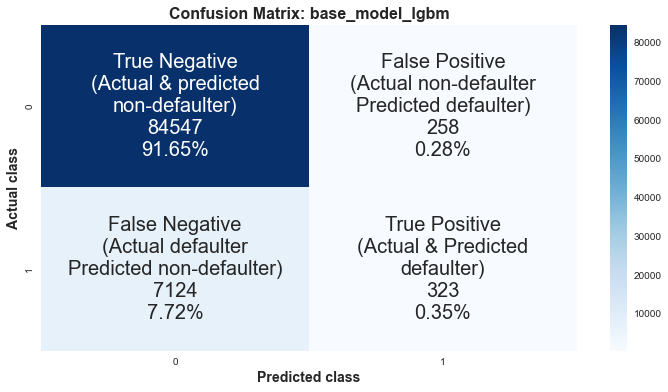

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.91998,0.555938,0.080468,0 days 00:00:39.691411


In [16]:
# Base model - LGBM
base_model_lgbm = LGBMClassifier()
df_res = metrics_display(base_model_lgbm,
                         X_train,
                         X_valid,
                         y_train,
                         y_valid,
                         'base_model_lgbm',
                         df_res)
df_res

#### Selected features

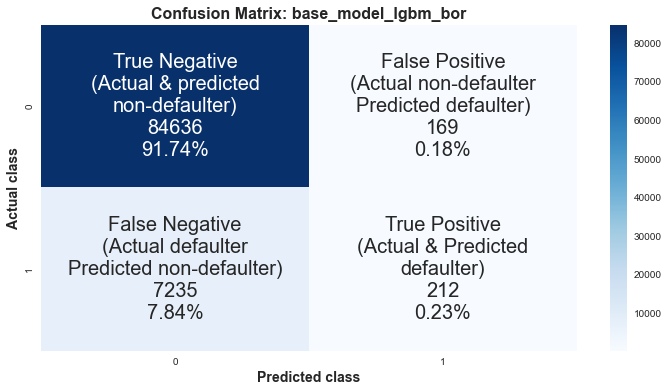

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,0 days 00:00:39.691411
1,base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,0 days 00:00:05.249995


In [17]:
# Base model - LGBM
base_model_lgbm_bor = LGBMClassifier()
df_res = metrics_display(base_model_lgbm_bor,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'base_model_lgbm_bor',
                         df_res)
df_res

### 2.3 XGBoost<a class="anchor" id="section_2_3"></a>

#### Full Dataset

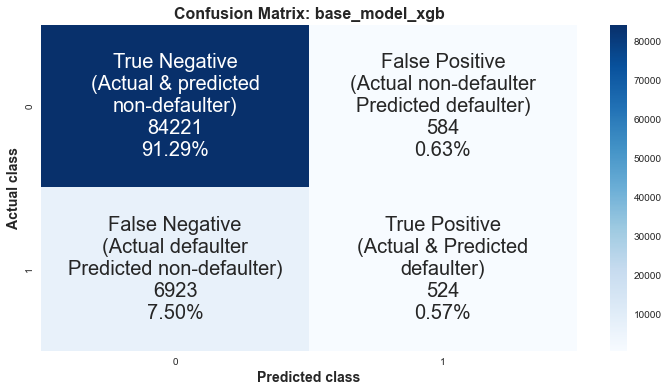

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,0 days 00:00:39.691411
1,base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,0 days 00:00:05.249995
2,base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,0 days 00:01:56.558198


In [18]:
base_model_xgb = XGBClassifier(eval_metric='mlogloss')
df_res = metrics_display(base_model_xgb,
                         X_train,
                         X_valid,
                         y_train,
                         y_valid,
                         'base_model_xgb',
                         df_res)
df_res

#### Features selected

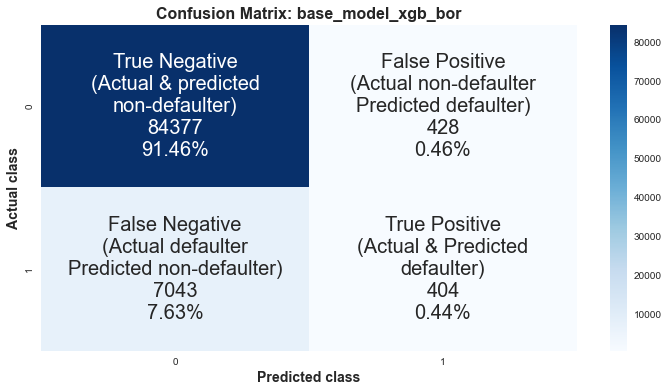

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,0 days 00:00:39.691411
1,base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,0 days 00:00:05.249995
2,base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,0 days 00:01:56.558198
3,base_model_xgb_bor,0.769478,0.054250,0.919015,0.485577,0.097596,0 days 00:00:19.849735


In [19]:
base_model_xgb_bor = XGBClassifier(eval_metric='mlogloss')
df_res = metrics_display(base_model_xgb_bor,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'base_model_xgb_bor',
                         df_res)
df_res

### 2.4 CatBoost<a class="anchor" id="section_2_4"></a>

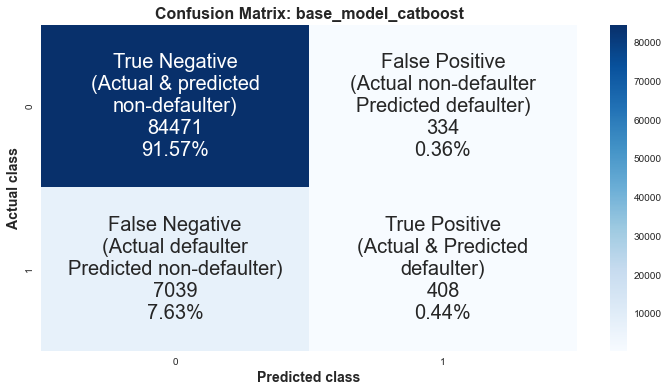

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,0 days 00:00:39.691411
1,base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,0 days 00:00:05.249995
2,base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,0 days 00:01:56.558198
3,base_model_xgb_bor,0.769478,0.054250,0.919015,0.485577,0.097596,0 days 00:00:19.849735
4,base_model_catboost,0.790446,0.054787,0.920078,0.549865,0.099646,0 days 00:03:31.475753


In [20]:
base_model_catboost = CatBoostClassifier()
df_res = metrics_display(base_model_catboost,
                         X_train,
                         X_valid,
                         y_train,
                         y_valid,
                         'base_model_catboost',
                         df_res)
df_res

#### Features selected

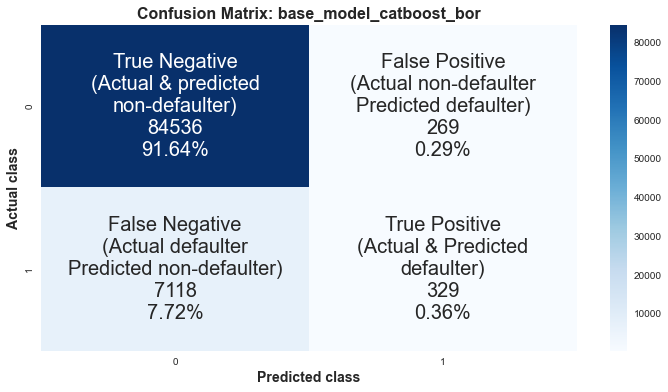

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,0 days 00:00:39.691411
1,base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,0 days 00:00:05.249995
2,base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,0 days 00:01:56.558198
3,base_model_xgb_bor,0.769478,0.054250,0.919015,0.485577,0.097596,0 days 00:00:19.849735
4,base_model_catboost,0.790446,0.054787,0.920078,0.549865,0.099646,0 days 00:03:31.475753
5,base_model_catboost_bor,0.782161,0.044179,0.919926,0.550167,0.081790,0 days 00:00:54.610969


In [21]:
base_model_catboost_bor = CatBoostClassifier()
df_res = metrics_display(base_model_catboost_bor,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'base_model_catboost_bor',
                         df_res)
df_res

In [59]:
# Summary of confusion matrices
metrics = ['TN(%)', 'TP(%)', 'FN(%)', 'FP(%)', 'NPV(%)']
data = {'base_model_lgbm' : pd.Series([
                                 TN(base_model_lgbm, y_valid, X_valid),
                                 TP(base_model_lgbm, y_valid, X_valid),
                                 FN(base_model_lgbm, y_valid, X_valid),
                                 FP(base_model_lgbm, y_valid, X_valid),
                                 NPV(base_model_lgbm, y_valid, X_valid)
                                 ], index = metrics),
        'base_model_lgbm_bor' : pd.Series([ 
                                 TN(base_model_lgbm_bor, y_valid_boruta, X_valid_boruta),
                                 TP(base_model_lgbm_bor, y_valid_boruta, X_valid_boruta),
                                 FN(base_model_lgbm_bor, y_valid_boruta, X_valid_boruta),
                                 FP(base_model_lgbm_bor, y_valid_boruta, X_valid_boruta),
                                 NPV(base_model_lgbm_bor, y_valid_boruta, X_valid_boruta)
                                 ], index = metrics),
        'base_model_catboost' : pd.Series([TN(base_model_catboost, y_valid, X_valid),
                                 TP(base_model_catboost, y_valid, X_valid),
                                 FN(base_model_catboost, y_valid, X_valid),
                                 FP(base_model_catboost, y_valid, X_valid),
                                 NPV(base_model_catboost, y_valid, X_valid)          
                                 ], index = metrics),
        'base_model_catboost_bor' : pd.Series([TN(base_model_catboost_bor, y_valid_boruta, X_valid_boruta),
                                 TP(base_model_catboost_bor, y_valid_boruta, X_valid_boruta),
                                 FN(base_model_catboost_bor, y_valid_boruta, X_valid_boruta),
                                 FP(base_model_catboost_bor, y_valid_boruta, X_valid_boruta),
                                 NPV(base_model_catboost_bor, y_valid_boruta, X_valid_boruta)              
                                 ], index = metrics),
        'base_model_xgb' : pd.Series([TN(base_model_xgb, y_valid, X_valid),
                                 TP(base_model_xgb, y_valid, X_valid),
                                 FN(base_model_xgb, y_valid, X_valid),
                                 FP(base_model_xgb, y_valid, X_valid),
                                 NPV(base_model_xgb, y_valid, X_valid)     
                                 ], index = metrics),
        'base_model_xgb_bor' : pd.Series([TN(base_model_xgb_bor, y_valid_boruta, X_valid_boruta),
                                 TP(base_model_xgb_bor, y_valid_boruta, X_valid_boruta),
                                 FN(base_model_xgb_bor, y_valid_boruta, X_valid_boruta),
                                 FP(base_model_xgb_bor, y_valid_boruta, X_valid_boruta),
                                 NPV(base_model_xgb_bor, y_valid_boruta, X_valid_boruta)         
                                 ], index = metrics)}

# Creates Dataframe df for individuals evaluation

df = pd.DataFrame(data)
index = df.index
index. name = "Model"
df_T = df.T

In [60]:
# Merging all metrics altogether
results_base = pd.merge(df_res, df_T, left_on = 'Model', right_index=True, how = 'left')
column_to_move = results_base.pop("Run time")
results_base.insert(11, "Run time", column_to_move )
results_base.set_index('Model', inplace=True)
results_base
results_base.sort_values('FN(%)', ascending=True, inplace=True)
cols = ['TN(%)', 'TP(%)', 'FN(%)', 'FP(%)']
results_base[cols] = results_base[cols].round(2)
results_base.to_pickle('results_base.pkl')
results_base

,AUC,Recall,Accuracy,Precision,F1,TN(%),TP(%),FN(%),FP(%),NPV(%),Run time
Model,,,,,,,,,,,
base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,91.29,0.57,7.50,0.63,7.60,0 days 00:01:56.558198
base_model_xgb_bor,0.769478,0.054250,0.919015,0.485577,0.097596,91.46,0.44,7.63,0.46,7.70,0 days 00:00:19.849735
base_model_catboost,0.790446,0.054787,0.920078,0.549865,0.099646,91.57,0.44,7.63,0.36,7.69,0 days 00:03:31.475753
base_model_lgbm,0.786118,0.043373,0.919980,0.555938,0.080468,91.65,0.35,7.72,0.28,7.77,0 days 00:00:39.691411
base_model_catboost_bor,0.782161,0.044179,0.919926,0.550167,0.081790,91.64,0.36,7.72,0.29,7.77,0 days 00:00:54.610969
base_model_lgbm_bor,0.777150,0.028468,0.919742,0.556430,0.054165,91.74,0.23,7.84,0.18,7.88,0 days 00:00:05.249995


In [61]:
# results_base = pd.read_pickle("results_base.pkl")
# results_base

With these base models, AUC ranges from 0.767 to 0.790. CatBoost & LGBM have the highest AUC on the full dataset. CatBoost running time is significantly higher than the 2 previous algorithms. In terms of FN %, XGB shows the lowest number of customers.

### 3. Impact of Synthetic Minority Oversampling Technique (SMOTE)<a class="anchor" id="chapter3"></a>

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.<br>

Reference: https://arxiv.org/abs/1106.1813

Let's investigate the impact of oversampling through SMOTE on our 3 best models (without hyper-parameters optimization) in order to speed up the process.

In [62]:
models_select = [CatBoostClassifier(logging_level='Silent'),
                 LGBMClassifier(),
                 XGBClassifier(eval_metric='mlogloss')] 

#### Full model

In [63]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))
sm = SMOTE(random_state=42)
X_train_resample, y_train_resample = sm.fit_sample(X_train, y_train)
print("Label 1, After using SMOTE: {}".format(sum(y_train_resample==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_resample==0)))

Label 1, Before using SMOTE: 17377 
Label 0, Before using SMOTE: 197877 
Label 1, After using SMOTE: 197877
Label 0, After using SMOTE: 197877


#### Selected features model (Ltd model)

In [64]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train_boruta==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train_boruta==0)))
oversample = SMOTE()
X_boruta_resample, y_boruta_resample = oversample.fit_resample(X_train_boruta, y_train_boruta)
print("Label 1, After using SMOTE: {}".format(sum(y_boruta_resample==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_boruta_resample==0)))

Label 1, Before using SMOTE: 17377 
Label 0, Before using SMOTE: 197877 
Label 1, After using SMOTE: 197877
Label 0, After using SMOTE: 197877


In [65]:
# start=datetime.now()
# name, auc, accuracy, precision = [], [], [], []
# recall, f1, time_ = [], [], []

# for model in models_select:
#     start_time = datetime.now()
#     results = train_models(model, X_train_resample, X_valid, y_train_resample, y_valid)

#     name.append(type(model).__name__)
#     auc.append(results['AUC'])
#     accuracy.append(results['Accuracy'])
#     precision.append(results['Precision'])
#     recall.append(results['Recall'])
#     f1.append(results['F1'])
#     time_.append(datetime.now() - start_time)

# #Initialise data of lists
# base_models_smote = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
# base_models_smote.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
# base_models_smote.sort_values('AUC', ascending=False, inplace=True)
# elapsed=datetime.now()-start
# print(f'Running Time of models comparison: {elapsed}')
# base_models_smote.to_pickle('base_models_smotetot.pkl')
# base_models_smote

In [66]:
base_models_smote = pd.read_pickle("base_models_smotetot.pkl")
base_models_smote

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.771941,0.918441,0.468365,0.076541,0.131579,0 days 00:06:04.793242
1,LGBMClassifier,0.76178,0.917129,0.39666,0.051027,0.090422,0 days 00:01:04.910727
2,XGBClassifier,0.75695,0.915763,0.40158,0.088761,0.145387,0 days 00:06:33.886858


#### Features selected model

In [67]:
# start=datetime.now()
# name, auc, accuracy, precision = [], [], [], []
# recall, f1, time_ = [], [], []

# for model in models_select:
#     start_time = datetime.now()
#     results = train_models(model, X_boruta_resample, X_valid_boruta, y_boruta_resample, y_valid_boruta)

#     name.append(type(model).__name__)
#     auc.append(results['AUC'])
#     accuracy.append(results['Accuracy'])
#     precision.append(results['Precision'])
#     recall.append(results['Recall'])
#     f1.append(results['F1'])
#     time_.append(datetime.now() - start_time)

# #Initialise data of lists
# base_models_smote_boruta = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
# base_models_smote_boruta.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
# base_models_smote_boruta.sort_values('AUC', ascending=False, inplace=True)
# elapsed=datetime.now()-start
# print(f'Running Time of models comparison: {elapsed}')
# base_models_smote_boruta.to_pickle('base_models_smote_bor.pkl')
# base_models_smote_boruta

In [68]:
base_models_smote_boruta = pd.read_pickle("base_models_smote_bor.pkl")
base_models_smote_boruta

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.762744,0.918083,0.450361,0.067007,0.116657,0 days 00:01:36.534805
2,XGBClassifier,0.749488,0.915763,0.388736,0.076004,0.127148,0 days 00:01:02.597539
1,LGBMClassifier,0.745255,0.915568,0.359836,0.05895,0.101304,0 days 00:00:10.022007


### LightGBM - Base parameters - SMOTE - Full Dataset

In [69]:
df_res_smote = pd.DataFrame({})

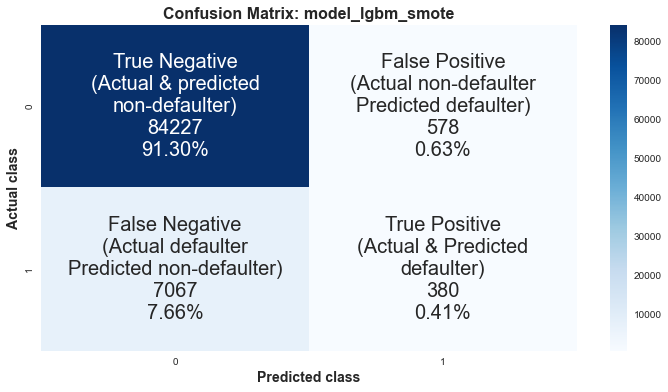

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.76178,0.051027,0.917129,0.39666,0.090422,0 days 00:01:25.751251


In [70]:
model_lgbm_smote = LGBMClassifier()
df_res_smote = metrics_display(model_lgbm_smote,
                         X_train_resample,
                         X_valid,
                         y_train_resample,
                         y_valid,
                         'model_lgbm_smote',
                         df_res_smote)
df_res_smote

### LightGBM - Base parameters - SMOTE - Ltd model

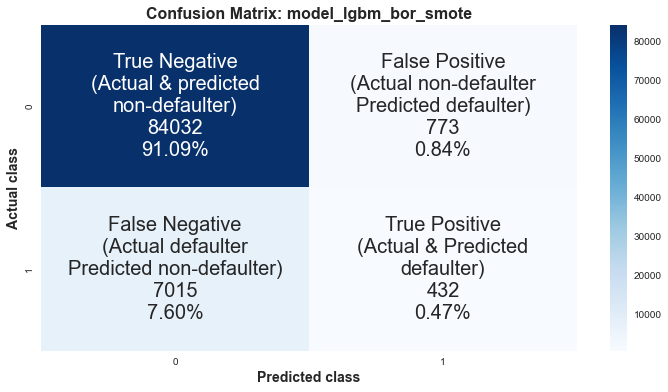

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,0 days 00:01:25.751251
1,model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,0 days 00:00:10.295988


In [71]:
model_lgbm_bor_smote = LGBMClassifier()
df_res_smote = metrics_display(model_lgbm_bor_smote,
                         X_boruta_resample,
                         X_valid_boruta,
                         y_boruta_resample,
                         y_valid_boruta,
                         'model_lgbm_bor_smote',
                         df_res_smote)
df_res_smote

### XGBoost - Base parameters - SMOTE - Full Dataset

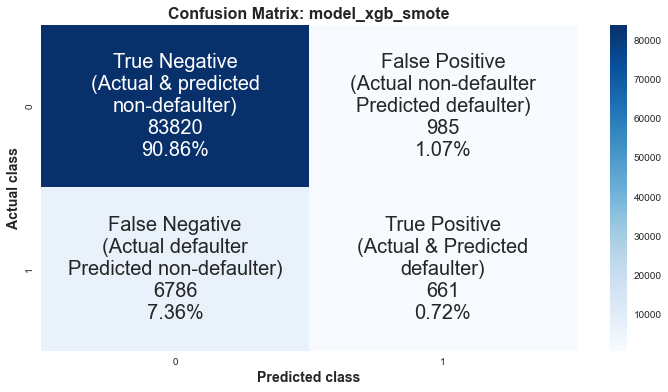

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,0 days 00:01:25.751251
1,model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,0 days 00:00:10.295988
2,model_xgb_smote,0.756950,0.088761,0.915763,0.401580,0.145387,0 days 00:09:06.052734


In [72]:
model_xgb_smote = XGBClassifier(eval_metric='mlogloss')
df_res_smote = metrics_display(model_xgb_smote,
                         X_train_resample,
                         X_valid,
                         y_train_resample,
                         y_valid,
                         'model_xgb_smote',
                         df_res_smote)
df_res_smote

### XGBoost - Base parameters - SMOTE - Ltd model

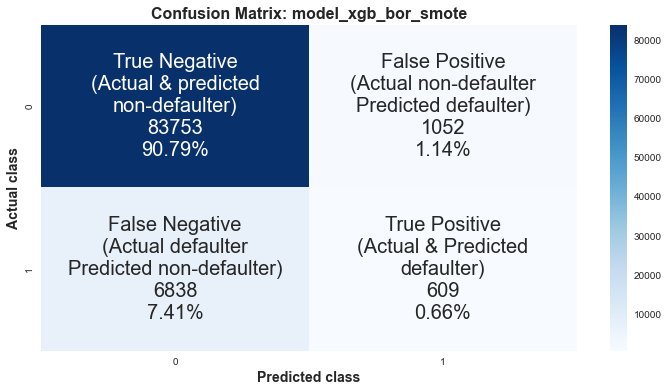

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,0 days 00:01:25.751251
1,model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,0 days 00:00:10.295988
2,model_xgb_smote,0.756950,0.088761,0.915763,0.401580,0.145387,0 days 00:09:06.052734
3,model_xgb_bor_smote,0.745917,0.081778,0.914473,0.366647,0.133729,0 days 00:01:09.483868


In [73]:
model_xgb_bor_smote = XGBClassifier(eval_metric='mlogloss')
df_res_smote = metrics_display(model_xgb_bor_smote,
                         X_boruta_resample,
                         X_valid_boruta,
                         y_boruta_resample,
                         y_valid_boruta,
                         'model_xgb_bor_smote',
                         df_res_smote)
df_res_smote

### CatBoost - Base parameters - SMOTE - Full Dataset

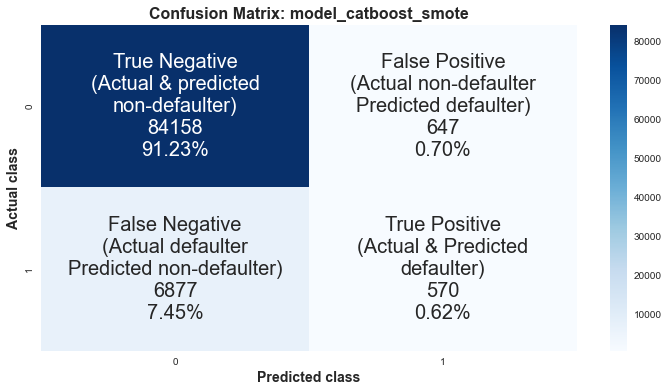

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,0 days 00:01:25.751251
1,model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,0 days 00:00:10.295988
2,model_xgb_smote,0.756950,0.088761,0.915763,0.401580,0.145387,0 days 00:09:06.052734
3,model_xgb_bor_smote,0.745917,0.081778,0.914473,0.366647,0.133729,0 days 00:01:09.483868
4,model_catboost_smote,0.771941,0.076541,0.918441,0.468365,0.131579,0 days 00:05:43.630274


In [74]:
model_catboost_smote = CatBoostClassifier()
df_res_smote = metrics_display(model_catboost_smote,
                         X_train_resample,
                         X_valid,
                         y_train_resample,
                         y_valid,
                         'model_catboost_smote',
                         df_res_smote)
df_res_smote

### CatBoost - Base parameters - SMOTE - Ltd model

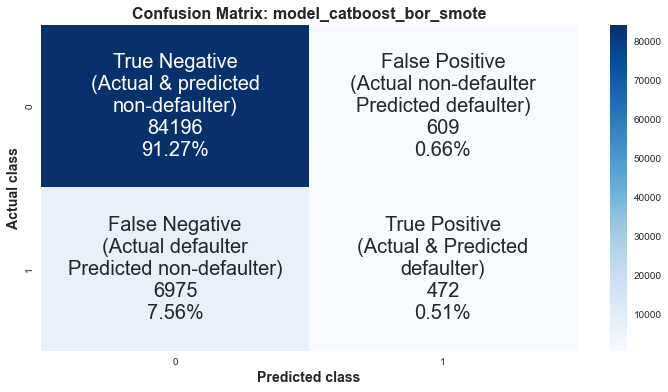

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,0 days 00:01:25.751251
1,model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,0 days 00:00:10.295988
2,model_xgb_smote,0.756950,0.088761,0.915763,0.401580,0.145387,0 days 00:09:06.052734
3,model_xgb_bor_smote,0.745917,0.081778,0.914473,0.366647,0.133729,0 days 00:01:09.483868
4,model_catboost_smote,0.771941,0.076541,0.918441,0.468365,0.131579,0 days 00:05:43.630274
5,model_catboost_bor_smote,0.762618,0.063381,0.917790,0.436633,0.110694,0 days 00:01:39.293389


In [75]:
model_catboost_bor_smote = CatBoostClassifier()
df_res_smote = metrics_display(model_catboost_bor_smote,
                         X_boruta_resample,
                         X_valid_boruta,
                         y_boruta_resample,
                         y_valid_boruta,
                         'model_catboost_bor_smote',
                         df_res_smote)
df_res_smote

In [76]:
# Summary of confusion matrices
metrics = ['TN(%)', 'TP(%)', "FN(%)", 'FP(%)', 'NPV(%)']
data_sm = {'model_lgbm_smote' : pd.Series([
                                 TN(model_lgbm_smote, y_valid, X_valid),
                                 FP(model_lgbm_smote, y_valid, X_valid),
                                 FN(model_lgbm_smote, y_valid, X_valid),
                                 TP(model_lgbm_smote, y_valid, X_valid),
                                 NPV(model_lgbm_smote, y_valid, X_valid)
                                 ], index = metrics),
        'model_lgbm_bor_smote' : pd.Series([ 
                                 TN(model_lgbm_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FP(model_lgbm_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FN(model_lgbm_bor_smote, y_valid_boruta, X_valid_boruta),
                                 TP(model_lgbm_bor_smote, y_valid_boruta, X_valid_boruta),
                                 NPV(model_lgbm_smote, y_valid, X_valid)
                                 ], index = metrics),
        'model_catboost_smote' : pd.Series([TN(model_catboost_smote, y_valid, X_valid),
                                 FP(model_catboost_smote, y_valid, X_valid),
                                 FN(model_catboost_smote, y_valid, X_valid),
                                 TP(model_catboost_smote, y_valid, X_valid),
                                 NPV(model_catboost_smote, y_valid, X_valid)           
                                 ], index = metrics),
        'model_catboost_bor_smote' : pd.Series([TN(model_catboost_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FP(model_catboost_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FN(model_catboost_bor_smote, y_valid_boruta, X_valid_boruta),
                                 TP(model_catboost_bor_smote, y_valid_boruta, X_valid_boruta),
                                 NPV(model_catboost_bor_smote, y_valid_boruta, X_valid_boruta)              
                                 ], index = metrics),
        'model_xgb_smote' : pd.Series([TN(model_xgb_smote, y_valid, X_valid),
                                 FP(model_xgb_smote, y_valid, X_valid),
                                 FN(model_xgb_smote, y_valid, X_valid),
                                 TP(model_xgb_smote, y_valid, X_valid),
                                 NPV(model_xgb_smote, y_valid, X_valid)     
                                 ], index = metrics),
        'model_xgb_bor_smote' : pd.Series([TN(model_xgb_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FP(model_xgb_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FN(model_xgb_bor_smote, y_valid_boruta, X_valid_boruta),
                                 TP(model_xgb_bor_smote, y_valid_boruta, X_valid_boruta),
                                 NPV(model_xgb_bor_smote, y_valid_boruta, X_valid_boruta)          
                                 ], index = metrics)}

# Creates Dataframe df for individuals evaluation

df_smote = pd.DataFrame(data_sm)
index = df_smote.index
index. name = "Models"
df_smoteT = df_smote.T

In [77]:
df_smoteT

Models,TN(%),TP(%),FN(%),FP(%),NPV(%)
model_lgbm_smote,91.30,0.63,7.66,0.41,7.74
model_lgbm_bor_smote,91.09,0.84,7.60,0.47,7.74
model_catboost_smote,91.23,0.70,7.45,0.62,7.55
model_catboost_bor_smote,91.27,0.66,7.56,0.51,7.65
model_xgb_smote,90.86,1.07,7.36,0.72,7.49
model_xgb_bor_smote,90.79,1.14,7.41,0.66,7.55


In [144]:
results_sm = pd.merge(df_res_smote, df_smoteT, left_on = 'Model', right_index=True, how = 'left')
column_to_move = results_sm.pop("Run time")
results_sm.insert(11, "Run time", column_to_move )
results_sm.set_index('Model', inplace=True)
cols = ['TN(%)', 'TP(%)', 'FN(%)', 'FP(%)']
results_sm[cols] = results_sm[cols].round(2)
total_results_base = results_sm.append(results_base)
total_results_base.sort_values('Recall', ascending=False, inplace=True)
total_results_base.to_pickle('total_results_base.pkl')
total_results_base

,AUC,Recall,Accuracy,Precision,F1,TN(%),TP(%),FN(%),FP(%),NPV(%),Run time
Model,,,,,,,,,,,
model_xgb_smote,0.756950,0.088761,0.915763,0.401580,0.145387,90.86,1.07,7.36,0.72,7.49,0 days 00:09:06.052734
model_xgb_bor_smote,0.745917,0.081778,0.914473,0.366647,0.133729,90.79,1.14,7.41,0.66,7.55,0 days 00:01:09.483868
model_catboost_smote,0.771941,0.076541,0.918441,0.468365,0.131579,91.23,0.70,7.45,0.62,7.55,0 days 00:05:43.630274
base_model_xgb,0.776058,0.070364,0.918625,0.472924,0.122501,91.29,0.57,7.50,0.63,7.60,0 days 00:01:56.558198
model_catboost_bor_smote,0.762618,0.063381,0.917790,0.436633,0.110694,91.27,0.66,7.56,0.51,7.65,0 days 00:01:39.293389
model_lgbm_bor_smote,0.744828,0.058010,0.915579,0.358506,0.099861,91.09,0.84,7.60,0.47,7.74,0 days 00:00:10.295988
base_model_catboost,0.790446,0.054787,0.920078,0.549865,0.099646,91.57,0.44,7.63,0.36,7.69,0 days 00:03:31.475753
base_model_xgb_bor,0.769478,0.054250,0.919015,0.485577,0.097596,91.46,0.44,7.63,0.46,7.70,0 days 00:00:19.849735
model_lgbm_smote,0.761780,0.051027,0.917129,0.396660,0.090422,91.30,0.63,7.66,0.41,7.74,0 days 00:01:25.751251


Class redistribution through SMOTE tends to increase the Recall metric.

### 4. OPTUNA Hyperparameters Optimization<a class="anchor" id="chapter4"></a>

The optimization process in Optuna requires a function called objective that:

* Includes the parameter grid to search as a dictionary
* Creates a model to try hyperparameter combination sets
* Fits the model to the data with a single candidate set
* Generates predictions using this model
* Scores the predictions based on user-defined metrics and returns it

In [79]:
df_met = pd.DataFrame({})

#### 4.1 LightGBM - Ltd model<a class="anchor" id="section_4_1"></a>

In [80]:
def objective_bor(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # 0.02
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # 34
        "max_depth": trial.suggest_int("max_depth", 3, 12), # 8
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "metric":'auc',
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": "balanced"
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="roc_auc_score",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ], # Add a pruning callback
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [81]:
# study_bor_lgbm = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
# func = lambda trial: objective_bor(trial)
# study_bor_lgbm.optimize(func, n_trials=20)
# joblib.dump(study_bor_lgbm, "study_bor_lgbm.pkl")

In [82]:
study_bor_lgbm = joblib.load("study_bor_lgbm.pkl")
print(f"\tBest value (AUC): {study_bor_lgbm.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.77346
	Best params:
		n_estimators: 10000
		learning_rate: 0.14514069717086192
		num_leaves: 2340
		max_depth: 5
		min_data_in_leaf: 9000
		lambda_l1: 20
		lambda_l2: 40
		min_gain_to_split: 11.311163569896387
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.5


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=11.311163569896387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.311163569896387
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


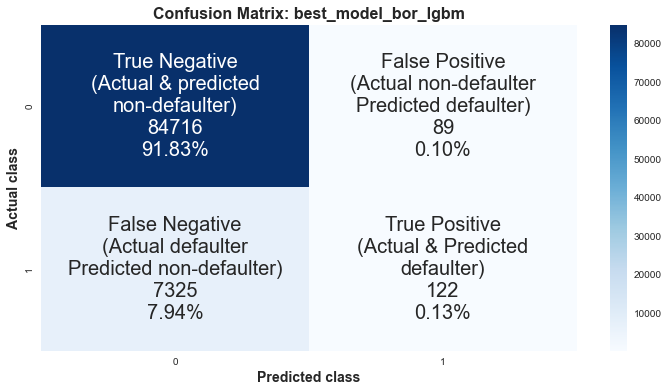

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909


In [83]:
bor_lgb_best_params = study_bor_lgbm.best_params
best_model_bor_lgbm = LGBMClassifier(**bor_lgb_best_params)
df_met = metrics_display(best_model_bor_lgbm,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_lgbm',
                         df_met)
df_met

#### 4.2 LightGBM - Class weight = balanced - Ltd model<a class="anchor" id="section_4_2"></a>

Every classification algorithm has a parameter namely class_weight. The different type of inputs to this parameter allows you to handle class imbalance using different manner. By default, when no value is passed, the weight assigned to each class is equal e.g., 1.<br>
Passing balanced as class_weight results in the values of y (label) to automatically adjust weights inversely proportional to class frequencies in the input data.

In [84]:
def objective_bor_w(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # 0.02
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # 34
        "max_depth": trial.suggest_int("max_depth", 3, 12), # 8
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "metric":'auc',
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "class_weight": "balanced",
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="roc_auc_score",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ], # Add a pruning callback
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [85]:
# study_bor_lgbm_w = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
# func = lambda trial: objective_bor_w(trial)
# study_bor_lgbm_w.optimize(func, n_trials=20)
# joblib.dump(study_bor_lgbm_w, "study_bor_lgbm_w.pkl")

In [86]:
study_bor_lgbm_w = joblib.load("study_bor_lgbm_w.pkl")
print(f"\tBest value (AUC): {study_bor_lgbm_w.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_lgbm_w.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.78083
	Best params:
		n_estimators: 10000
		learning_rate: 0.18471176906339712
		num_leaves: 2980
		max_depth: 11
		min_data_in_leaf: 3300
		lambda_l1: 0
		lambda_l2: 85
		min_gain_to_split: 14.908700290759823
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=14.908700290759823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.908700290759823
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


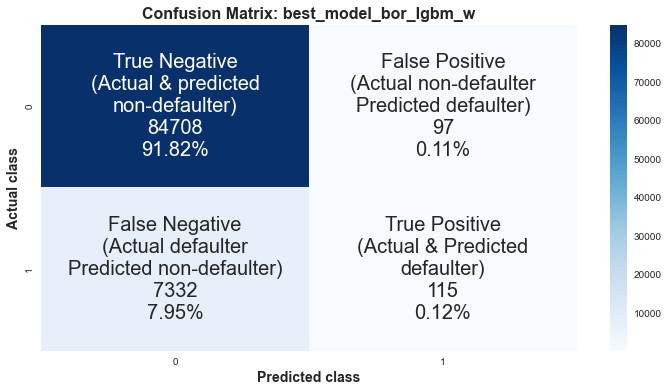

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416


In [87]:
bor_lgb_w_best_params = study_bor_lgbm_w.best_params
best_model_bor_lgbm_w = LGBMClassifier(**bor_lgb_w_best_params)
df_met = metrics_display(best_model_bor_lgbm_w,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_lgbm_w',
                         df_met)
df_met

#### 4.3 LightGBM - SMOTE - Ltd model<a class="anchor" id="section_4_3"></a>

We should split into training and validation folds. Then, on each fold, we have to:

* Oversample the minority class
* Train the classifier on the training folds
* Validate the classifier on the remaining fold

By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable.

In [88]:
def objective_bor_smote(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "metric":'auc',
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": 'balanced'
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    smoter = SMOTE(random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]
        
        # Upsample only the data in the training section
        X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_upsample,
            y_train_upsample,
            eval_set=[(X_test, y_test)],
            eval_metric="roc_auc_score",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ], # Add a pruning callback
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [89]:
# study_bor_smote = optuna.create_study(direction="maximize", study_name="LGBM Classifier - SMOTE")
# func = lambda trial: objective_bor_smote(trial)
# study_bor_smote.optimize(func, n_trials=20)
# joblib.dump(study_bor_smote, "study_bor_smote.pkl")

In [90]:
study_bor_smote = joblib.load("study_bor_smote.pkl")
print(f"\tBest value (AUC): {study_bor_smote.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_smote.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.75996
	Best params:
		n_estimators: 10000
		learning_rate: 0.03564755443923446
		num_leaves: 1260
		max_depth: 5
		min_data_in_leaf: 2200
		lambda_l1: 10
		lambda_l2: 40
		min_gain_to_split: 4.069499739198488
		bagging_fraction: 0.5
		bagging_freq: 1
		feature_fraction: 0.8


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=4.069499739198488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069499739198488
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


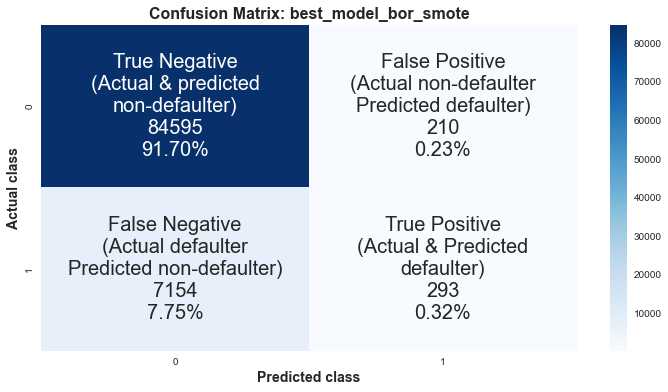

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042


In [91]:
lgb_best_params_bor_smote=study_bor_smote.best_params
best_model_bor_smote = LGBMClassifier(**lgb_best_params_bor_smote)
df_met = metrics_display(best_model_bor_smote,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_smote',
                         df_met)
df_met

#### SMOTE and class_weight=balanced on Ltd model

In [92]:
def objective_bor_smote_w(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "metric":'auc',
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "class_weight": 'balanced',
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    smoter = SMOTE(random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]
        
        # Upsample only the data in the training section
        X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_upsample,
            y_train_upsample,
            eval_set=[(X_test, y_test)],
            eval_metric="roc_auc_score",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ], # Add a pruning callback
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [93]:
# study_bor_smote_w = optuna.create_study(direction="maximize", study_name="LGBM Classifier - SMOTE")
# func = lambda trial: objective_bor_smote_w(trial)
# study_bor_smote_w.optimize(func, n_trials=20)
# joblib.dump(study_bor_smote_w, "study_bor_smote_w.pkl")

In [94]:
study_bor_smote_w = joblib.load("study_bor_smote_w.pkl")
print(f"\tBest value (AUC): {study_bor_smote_w.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_smote_w.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.77006
	Best params:
		n_estimators: 10000
		learning_rate: 0.023221710161369064
		num_leaves: 1860
		max_depth: 6
		min_data_in_leaf: 2300
		lambda_l1: 0
		lambda_l2: 95
		min_gain_to_split: 0.6330111263027244
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.5


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.6330111263027244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6330111263027244
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


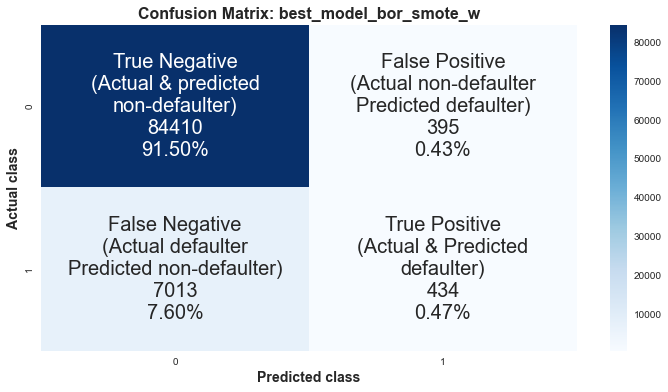

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636


In [95]:
lgb_best_params_bor_smote_w=study_bor_smote_w.best_params
best_model_bor_smote_w = LGBMClassifier(**lgb_best_params_bor_smote_w)
df_met = metrics_display(best_model_bor_smote_w,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_smote_w',
                         df_met)
df_met

### Cost Function

The metrics we decided to pick in order to evaluate our models do not penalize False Negative. In our problem, as we want to prevent the bank to grant loans to defaulters so that it does not lose too much money, we need to reduce False Negative as much as we can. We defined a cost function with a score penalizing False Negative.<br>
This new custom score has to be optimized i.e. the greater the score is, the better it is. However, we will apply some weights to the categories we want to minimze.<br>
We used twice the same function but with different weights. The custome_score can be found in func_modP7.py


In [96]:
def custom_score1(y_true, y_pred, tn_weight=1, fp_weight=-5, fn_weight=-20, tp_weight=0):
    '''
    Custom score penalizing False negatives.
    Parameters
    ----------
    y_true : True class (0 or 1).
    y_pred : Predicted class (0 or 1).
    tn_weight : True Negative, loan is paid back, good for the bank (default value=1)
              
    fp_weight : False positive, loan is refused while the customer is a non-defaulter
               Bank will lose the interests (Type I error)(default value=0),
               To penalize
    fn_weight : False negative, loan is granted to a defaulter
               Bank will lose lots of money (Type II error)(default value=-10)
               To penalize,
    tp_weight : True positive, loan is refused as the customer is a defaulter (default value=1),
               Neutral for the bank, money not lost but not gained either
    Returns
    -------
    custom score : Normalize gain (between 0 & 1), greater is better
    '''
    # Confusion matrix
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    # Total gain
    total_gain = tn * tn_weight + fp * fp_weight + fn * fn_weight + tp * tp_weight
    # Max gain : All predictions are correct
    max_gain = (fp + tn) * tn_weight + (fn + tp) * tp_weight
    # Min Gain: Any loan is refused, bank does not make any money
    min_gain = (fp + tn) * fp_weight + (fn + tp) * fn_weight
    
    custom_score = (total_gain - min_gain) / (max_gain - min_gain)
    
    return custom_score

In [97]:
eval_score = make_scorer(custom_score,
                            greater_is_better=True)

In [98]:
eval_score1 = make_scorer(custom_score1,
                            greater_is_better=True)

#### 4.4 LightGBM - Eval metrics = cost function<a class="anchor" id="section_4_4"></a>

In [99]:
def objective_bor_cost(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # 0.02
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # 34
        "max_depth": trial.suggest_int("max_depth", 3, 12), # 8
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": "balanced",
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score",
            early_stopping_rounds=100,
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [100]:
# study_bor_cost = optuna.create_study(direction="maximize", study_name="LGBM Classifier - Cost function")
# func = lambda trial: objective_bor_cost(trial)
# study_bor_cost.optimize(func, n_trials=20)
# joblib.dump(study_bor_cost, "study_bor_cost.pkl")

In [101]:
study_bor_cost = joblib.load("study_bor_cost.pkl")
print(f"\tBest value (AUC): {study_bor_cost.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_cost.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.78158
	Best params:
		n_estimators: 10000
		learning_rate: 0.03642918635602981
		num_leaves: 900
		max_depth: 8
		min_data_in_leaf: 5100
		lambda_l1: 60
		lambda_l2: 70
		min_gain_to_split: 0.21264039146275138
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.6000000000000001


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.21264039146275138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21264039146275138
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


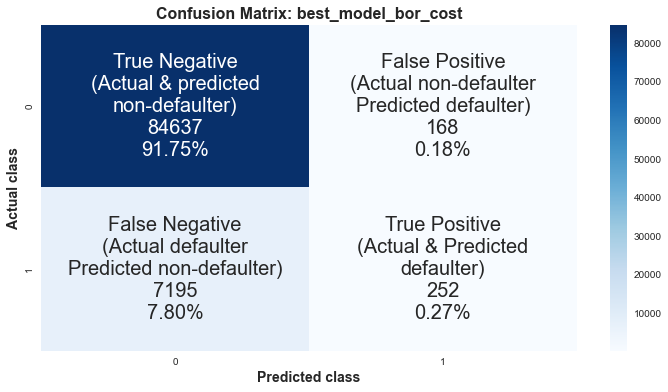

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358


In [102]:
lgb_best_params_bor_cost=study_bor_cost.best_params
best_model_bor_cost = LGBMClassifier(**lgb_best_params_bor_cost)
df_met = metrics_display(best_model_bor_cost,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_cost',
                         df_met)
df_met

#### 4.5 LightGBM - Class weight = balanced - Eval metrics = cost function<a class="anchor" id="section_4_5"></a>

In [103]:
def objective_bor_w_cost(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # 0.02
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # 34
        "max_depth": trial.suggest_int("max_depth", 3, 12), # 8
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "class_weight": "balanced",
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score",
            early_stopping_rounds=100,
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [104]:
# study_bor_w_cost = optuna.create_study(direction="maximize", study_name="LGBM Classifier - Cost function")
# func = lambda trial: objective_bor_w_cost(trial)
# study_bor_w_cost.optimize(func, n_trials=20)
# joblib.dump(study_bor_w_cost, "study_bor_w_cost.pkl")

In [105]:
study_bor_w_cost = joblib.load("study_bor_w_cost.pkl")
print(f"\tBest value (AUC): {study_bor_w_cost.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_w_cost.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.78353
	Best params:
		n_estimators: 10000
		learning_rate: 0.08316792550888283
		num_leaves: 2900
		max_depth: 12
		min_data_in_leaf: 1700
		lambda_l1: 50
		lambda_l2: 40
		min_gain_to_split: 6.45368798655402
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.5


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=6.45368798655402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.45368798655402
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


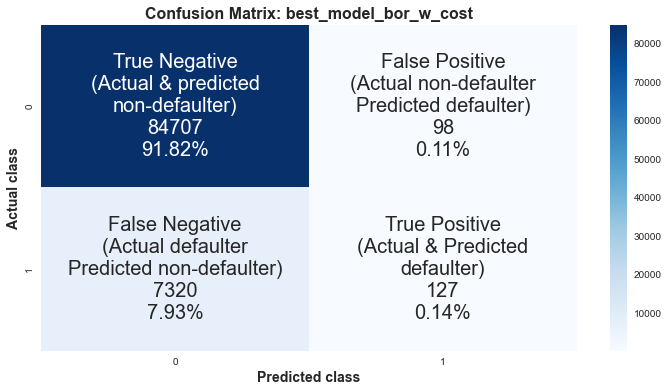

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358
5,best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,0 days 00:00:58.935055


In [106]:
lgb_best_params_bor_w_cost=study_bor_w_cost.best_params
best_model_bor_w_cost = LGBMClassifier(**lgb_best_params_bor_w_cost)
df_met = metrics_display(best_model_bor_w_cost,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_w_cost',
                         df_met)
df_met

#### 4.6 LightGBM - SMOTE - Eval metrics = cost function<a class="anchor" id="section_4_6"></a>

In [107]:
def objective_bor_smote_cost(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": 'balanced',
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    smoter = SMOTE(random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]
        
        # Upsample only the data in the training section
        X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_upsample,
            y_train_upsample,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score",
            early_stopping_rounds=100,
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [108]:
# study_bor_smote_cost = optuna.create_study(direction="maximize", study_name="LGBM Classifier - SMOTE")
# func = lambda trial: objective_bor_smote_cost(trial)
# study_bor_smote_cost.optimize(func, n_trials=20)
# joblib.dump(study_bor_smote_cost, "study_bor_smote_cost.pkl")

In [109]:
study_bor_smote_cost = joblib.load("study_bor_smote_cost.pkl")
print(f"\tBest value (AUC): {study_bor_smote_cost.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_smote_cost.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.76146
	Best params:
		n_estimators: 10000
		learning_rate: 0.020419190508660895
		num_leaves: 1760
		max_depth: 7
		min_data_in_leaf: 1100
		lambda_l1: 20
		lambda_l2: 0
		min_gain_to_split: 4.8526367188942565
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.4


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.8526367188942565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8526367188942565
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


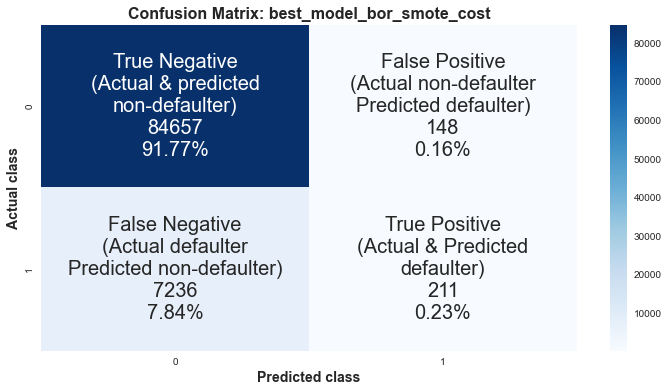

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358
5,best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,0 days 00:00:58.935055
6,best_model_bor_smote_cost,0.781845,0.028334,0.919958,0.587744,0.054061,0 days 00:00:59.481766


In [110]:
lgb_best_params_bor_smote_cost=study_bor_smote_cost.best_params
best_model_bor_smote_cost = LGBMClassifier(**lgb_best_params_bor_smote_cost)
df_met = metrics_display(best_model_bor_smote_cost,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_smote_cost',
                         df_met)
df_met

#### 4.7 LightGBM - Eval metrics = cost function1<a class="anchor" id="section_4_7"></a>

In [111]:
def objective_bor_cost1(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), # 0.02
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), # 34
        "max_depth": trial.suggest_int("max_depth", 3, 12), # 8
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#        "metric":'eval_score',
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": "balanced",
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score1",
            early_stopping_rounds=100,
#             callbacks=[
#                 LightGBMPruningCallback(trial, "auc")
#             ], # Add a pruning callback
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [112]:
# study_bor_cost1 = optuna.create_study(direction="maximize", study_name="LGBM Classifier - Cost function")
# func = lambda trial: objective_bor_cost1(trial)
# study_bor_cost1.optimize(func, n_trials=20)
# joblib.dump(study_bor_cost1, "study_bor_cost1.pkl")

In [113]:
study_bor_cost1 = joblib.load("study_bor_cost1.pkl")
print(f"\tBest value (AUC): {study_bor_cost1.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_cost1.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.78446
	Best params:
		n_estimators: 10000
		learning_rate: 0.13063479200198555
		num_leaves: 620
		max_depth: 4
		min_data_in_leaf: 1600
		lambda_l1: 25
		lambda_l2: 25
		min_gain_to_split: 0.017084424681205856
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.4


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.017084424681205856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017084424681205856
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


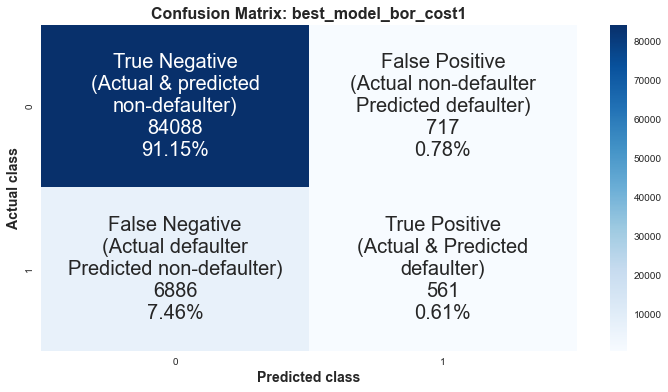

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358
5,best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,0 days 00:00:58.935055
6,best_model_bor_smote_cost,0.781845,0.028334,0.919958,0.587744,0.054061,0 days 00:00:59.481766
7,best_model_bor_cost1,0.764133,0.075332,0.917584,0.438967,0.128596,0 days 00:01:49.134742


In [114]:
lgb_best_params_bor_cost1=study_bor_cost1.best_params
best_model_bor_cost1 = LGBMClassifier(**lgb_best_params_bor_cost1)
df_met = metrics_display(best_model_bor_cost1,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_cost1',
                         df_met)
df_met

#### 4.8 LightGBM - Class weight = balanced - eval metrics = cost function1<a class="anchor" id="section_4_8"></a>

In [115]:
def objective_bor_cost1_w(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), 
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20), 
        "max_depth": trial.suggest_int("max_depth", 3, 12), 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "class_weight": "balanced",
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score1",
            early_stopping_rounds=100,
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [116]:
# study_bor_cost1_w = optuna.create_study(direction="maximize", study_name="LGBM Classifier - Cost function")
# func = lambda trial: objective_bor_cost1_w(trial)
# study_bor_cost1_w.optimize(func, n_trials=20)
# joblib.dump(study_bor_cost1_w, "study_bor_cost1_w.pkl")

In [117]:
study_bor_cost1_w = joblib.load("study_bor_cost1_w.pkl")
print(f"\tBest value (AUC): {study_bor_cost1_w.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_cost1_w.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.78509
	Best params:
		n_estimators: 10000
		learning_rate: 0.042804863304402294
		num_leaves: 2780
		max_depth: 5
		min_data_in_leaf: 7500
		lambda_l1: 5
		lambda_l2: 85
		min_gain_to_split: 4.578085415059906
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.8


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=4.578085415059906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.578085415059906
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


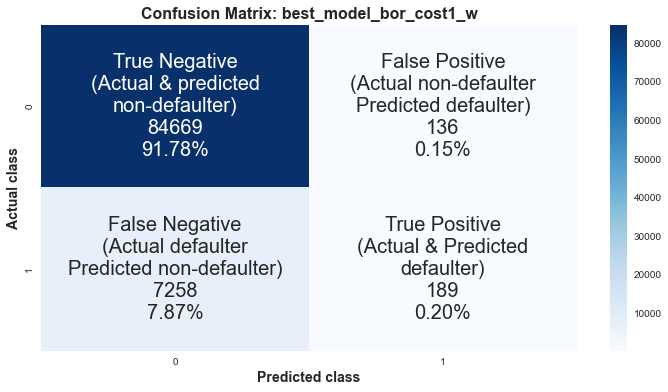

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358
5,best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,0 days 00:00:58.935055
6,best_model_bor_smote_cost,0.781845,0.028334,0.919958,0.587744,0.054061,0 days 00:00:59.481766
7,best_model_bor_cost1,0.764133,0.075332,0.917584,0.438967,0.128596,0 days 00:01:49.134742
8,best_model_bor_cost1_w,0.781455,0.025379,0.919850,0.581538,0.048636,0 days 00:00:59.813173


In [118]:
lgb_best_params_bor_cost1_w=study_bor_cost1_w.best_params
best_model_bor_cost1_w = LGBMClassifier(**lgb_best_params_bor_cost1_w)
df_met = metrics_display(best_model_bor_cost1_w,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_cost1_w',
                         df_met)
df_met

#### 4.9 LightGBM - SMOTE - Eval metrics = cost function1<a class="anchor" id="section_4_9"></a>

In [119]:
def objective_bor_smote_cost1(trial):
    param_grid = {
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
#        "class_weight": 'balanced',
        "verbose": -1,
        "silent": -1
    }
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    smoter = SMOTE(random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_boruta, y_boruta)):
        X_train, X_test = X_boruta.iloc[train_idx], X_boruta.iloc[test_idx]
        y_train, y_test = y_boruta[train_idx], y_boruta[test_idx]
        
        # Upsample only the data in the training section
        X_train_upsample, y_train_upsample = smoter.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_upsample,
            y_train_upsample,
            eval_set=[(X_test, y_test)],
            eval_metric="eval_score",
            early_stopping_rounds=100,
            verbose = False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

In [120]:
# study_bor_smote_cost1 = optuna.create_study(direction="maximize", study_name="LGBM Classifier - SMOTE")
# func = lambda trial: objective_bor_smote_cost1(trial)
# study_bor_smote_cost1.optimize(func, n_trials=20)
# joblib.dump(study_bor_smote_cost1, "study_bor_smote_cost1.pkl")

In [121]:
study_bor_smote_cost1 = joblib.load("study_bor_smote_cost1.pkl")
print(f"\tBest value (AUC): {study_bor_smote_cost1.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_bor_smote_cost1.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.76977
	Best params:
		n_estimators: 10000
		learning_rate: 0.035680616989923794
		num_leaves: 2420
		max_depth: 12
		min_data_in_leaf: 300
		lambda_l1: 60
		lambda_l2: 0
		min_gain_to_split: 0.041002806218063625
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.6000000000000001


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.041002806218063625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041002806218063625
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


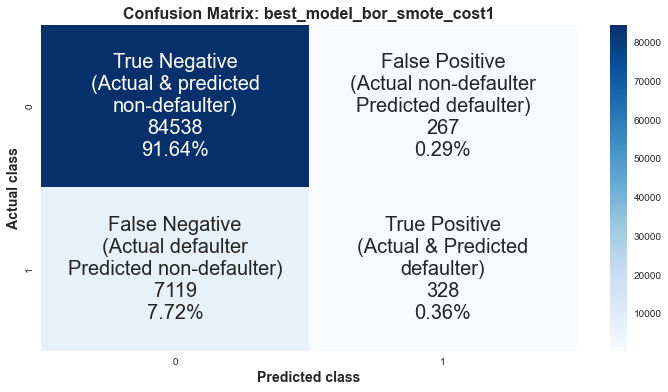

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,0 days 00:01:02.687909
1,best_model_bor_lgbm_w,0.774445,0.015442,0.919471,0.542453,0.030030,0 days 00:01:08.708416
2,best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,0 days 00:01:44.632042
3,best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,0 days 00:02:18.205636
4,best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,0 days 00:01:28.170358
5,best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,0 days 00:00:58.935055
6,best_model_bor_smote_cost,0.781845,0.028334,0.919958,0.587744,0.054061,0 days 00:00:59.481766
7,best_model_bor_cost1,0.764133,0.075332,0.917584,0.438967,0.128596,0 days 00:01:49.134742
8,best_model_bor_cost1_w,0.781455,0.025379,0.919850,0.581538,0.048636,0 days 00:00:59.813173
9,best_model_bor_smote_cost1,0.784576,0.044045,0.919937,0.551261,0.081572,0 days 00:01:36.842269


In [122]:
lgb_best_params_bor_smote_cost1=study_bor_smote_cost1.best_params
best_model_bor_smote_cost1 = LGBMClassifier(**lgb_best_params_bor_smote_cost1)
df_met = metrics_display(best_model_bor_smote_cost1,
                         X_train_boruta,
                         X_valid_boruta,
                         y_train_boruta,
                         y_valid_boruta,
                         'best_model_bor_smote_cost1',
                         df_met)
df_met

In [123]:
# Summary of confusion matrices
metrics = ['TN(%)', 'TP(%)', "FN(%)", 'FP(%)', 'NPV(%)']
data_op = {
        'best_model_bor_lgbm' : pd.Series([TN(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta)         
                                 ], index = metrics),
        'best_model_bor_lgbm_w' : pd.Series([TN(best_model_bor_lgbm_w, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_lgbm_w, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_lgbm_w, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_lgbm_w, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_lgbm, y_valid_boruta, X_valid_boruta)
                                 ], index = metrics),
        'best_model_bor_smote' : pd.Series([TN(best_model_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_smote, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_smote, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_smote, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_smote, y_valid_boruta, X_valid_boruta)
                                 ], index = metrics),
        'best_model_bor_smote_w' : pd.Series([TN(best_model_bor_smote_w, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_smote_w, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_smote_w, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_smote_w, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_smote_w, y_valid_boruta, X_valid_boruta)             
                                 ], index = metrics),
        'best_model_bor_cost' : pd.Series([TN(best_model_bor_cost, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_cost, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_cost, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_cost, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_cost, y_valid_boruta, X_valid_boruta)                                      
                                 ], index = metrics),
        'best_model_bor_w_cost' : pd.Series([TN(best_model_bor_w_cost, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_w_cost, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_w_cost, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_w_cost, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_w_cost, y_valid_boruta, X_valid_boruta)           
                                 ], index = metrics),
        'best_model_bor_smote_cost' : pd.Series([TN(best_model_bor_smote_cost, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_smote_cost, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_smote_cost, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_smote_cost, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_smote_cost, y_valid_boruta, X_valid_boruta)                
                                 ], index = metrics),
          'best_model_bor_cost1' : pd.Series([TN(best_model_bor_cost1, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_cost1, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_cost1, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_cost1, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_cost1, y_valid_boruta, X_valid_boruta)             
                                 ], index = metrics),
        'best_model_bor_cost1_w' : pd.Series([TN(best_model_bor_cost1_w, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_cost1_w, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_cost1_w, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_cost1_w, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_cost1_w, y_valid_boruta, X_valid_boruta)             
                                 ], index = metrics),
        'best_model_bor_smote_cost1' : pd.Series([TN(best_model_bor_smote_cost1, y_valid_boruta, X_valid_boruta),
                                 FP(best_model_bor_smote_cost1, y_valid_boruta, X_valid_boruta),
                                 FN(best_model_bor_smote_cost1, y_valid_boruta, X_valid_boruta),
                                 TP(best_model_bor_smote_cost1, y_valid_boruta, X_valid_boruta),
                                 NPV(best_model_bor_smote_cost1, y_valid_boruta, X_valid_boruta)                 
                                 ], index = metrics)
          }

# Creates Dataframe df for individuals evaluation

df_op = pd.DataFrame(data_op)
index = df_op.index
index. name = "Models"
df_opT = df_op.T

In [124]:
results_op = pd.merge(df_met, df_opT, left_on = 'Model', right_index=True, how = 'left')
column_to_move = results_op.pop("Run time")
results_op.insert(11, "Run time", column_to_move )
results_op.set_index('Model', inplace=True)
results_op.sort_values('FN(%)', ascending=True, inplace=True)
cols = ['TN(%)', 'TP(%)', 'FN(%)', 'FP(%)', 'NPV(%)']
results_op[cols] = results_op[cols].round(2)
results_op

,AUC,Recall,Accuracy,Precision,F1,TN(%),TP(%),FN(%),FP(%),NPV(%),Run time
Model,,,,,,,,,,,
best_model_bor_cost1,0.764133,0.075332,0.917584,0.438967,0.128596,91.15,0.78,7.46,0.61,7.57,0 days 00:01:49.134742
best_model_bor_smote_w,0.779408,0.058279,0.919698,0.523522,0.104882,91.50,0.43,7.60,0.47,7.67,0 days 00:02:18.205636
best_model_bor_smote_cost1,0.784576,0.044045,0.919937,0.551261,0.081572,91.64,0.29,7.72,0.36,7.77,0 days 00:01:36.842269
best_model_bor_smote,0.785139,0.039345,0.920175,0.582505,0.073711,91.70,0.23,7.75,0.32,7.80,0 days 00:01:44.632042
best_model_bor_cost,0.783239,0.033839,0.920186,0.600000,0.064065,91.75,0.18,7.80,0.27,7.83,0 days 00:01:28.170358
best_model_bor_smote_cost,0.781845,0.028334,0.919958,0.587744,0.054061,91.77,0.16,7.84,0.23,7.87,0 days 00:00:59.481766
best_model_bor_cost1_w,0.781455,0.025379,0.919850,0.581538,0.048636,91.78,0.15,7.87,0.20,7.90,0 days 00:00:59.813173
best_model_bor_w_cost,0.774481,0.017054,0.919590,0.564444,0.033107,91.82,0.11,7.93,0.14,7.95,0 days 00:00:58.935055
best_model_bor_lgbm,0.774335,0.016382,0.919633,0.578199,0.031862,91.83,0.10,7.94,0.13,7.96,0 days 00:01:02.687909


### 5. Solvency threshold determination<a class="anchor" id="chapter5"></a>

In [125]:
def threshold_solvency(model, X_valid, y_valid, title, n=1):
    '''
    Optimal solvency threshold determination.

    '''
    thresholds = np.arange(0, 1, 0.05)
    sav_gains = []
 
    for threshold in thresholds:

        # Model scoring : n = 0 or 1
        y_proba = model.predict_proba(X_valid)[:, n]

        # Score > solvency threshold returns 1
        y_pred = (y_proba > threshold)
        y_pred = np.multiply(y_pred, 1)
        
        # Saving score
        sav_gains.append(custom_score(y_valid, y_pred))
    
    df_score = pd.DataFrame({'Thresholds' : thresholds,
                             'Gain' : sav_gains})
    
    # Max custom score
    max_gain = df_score['Gain'].max()
    print(f'Max custom score: {max_gain}')
    # Best threshold
    max_threshold = df_score.loc[df_score['Gain'].argmax(), 'Thresholds']
    print(f'Max threshold : {max_threshold}')

    # custom score v solvency threshold
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, sav_gains)
    plt.xlabel('Solvency threshold')
    plt.ylabel('Custom_score')
    plt.title(title)
    plt.xticks(np.linspace(0.1, 1, 10))

Max custom score: 0.7070161670067493
Max threshold : 0.1


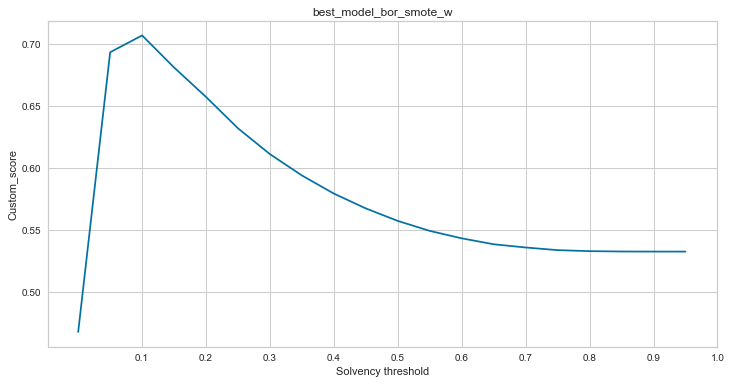

In [126]:
threshold_solvency(best_model_bor_smote_w, X_valid_boruta, y_valid_boruta, 'best_model_bor_smote_w')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.6330111263027244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6330111263027244
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


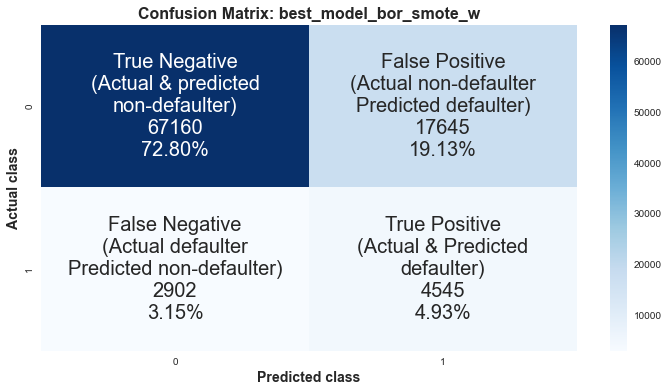

,Model,AUC,Recall,Accuracy,Precision,F1,Run time
0,best_model_bor_smote_w,0.779408,0.610313,0.777273,0.204822,0.306711,0 days 00:02:13.324224


In [127]:
df_res_threshold = pd.DataFrame({})
metrics_display_threshold(best_model_bor_smote_w,
                          0.1,
                          X_train_boruta,
                          X_valid_boruta,
                          y_train_boruta,
                          y_valid_boruta,
                          'best_model_bor_smote_w',
                          df_res_threshold)

As seen on the graph above, an optimal solvency threshold of 0.1 is found to be optimal which means all customers with a threshold higher than 0.1 would be considered as Defaulters. Looking at the confusion matrix, we detect much less False negative but more False Positive. A balance between those two needs to be discussed with the management team but as for now we keep this threshold.

### Features importance

Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

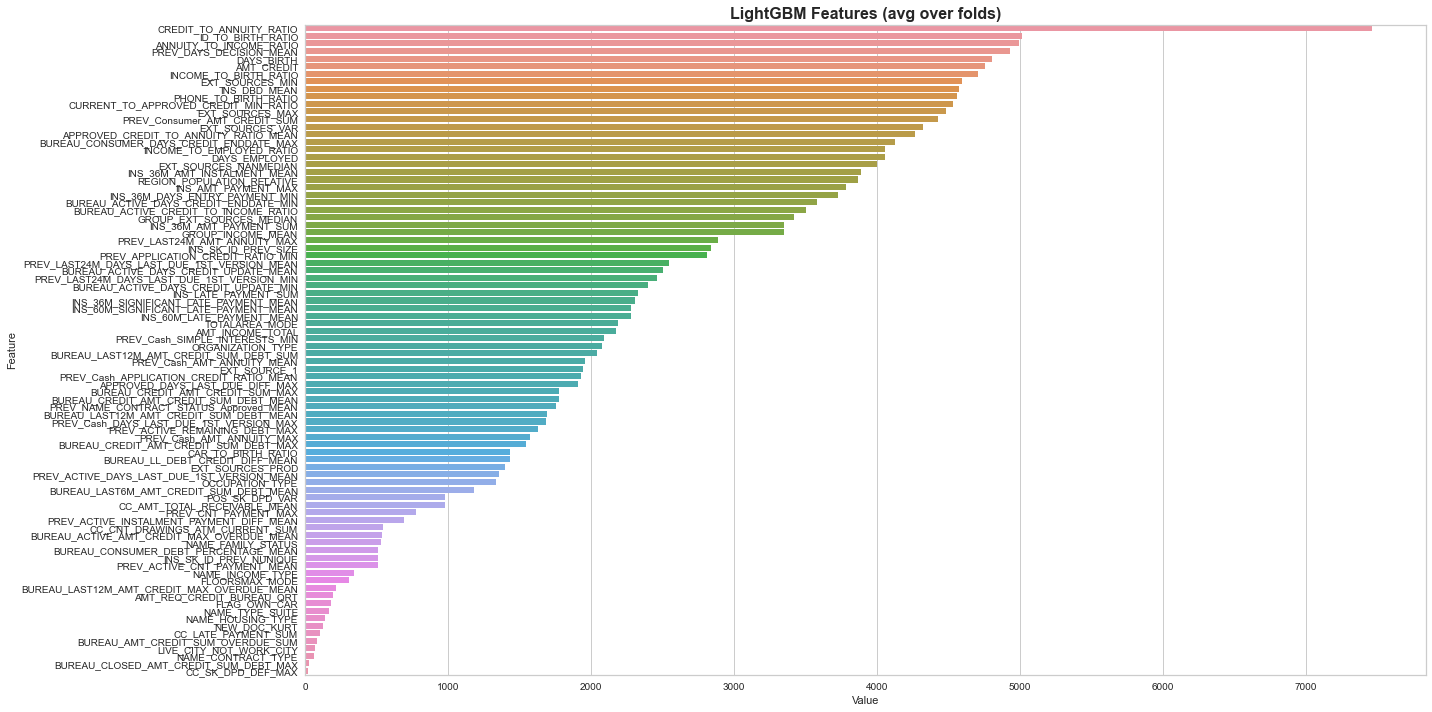

In [128]:
sorted(zip(best_model_bor_smote_w.feature_importances_, X_boruta.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(best_model_bor_smote_w.feature_importances_,X_train_boruta.columns)),
                           columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)', weight='bold', size=16)
plt.tight_layout()
plt.show()

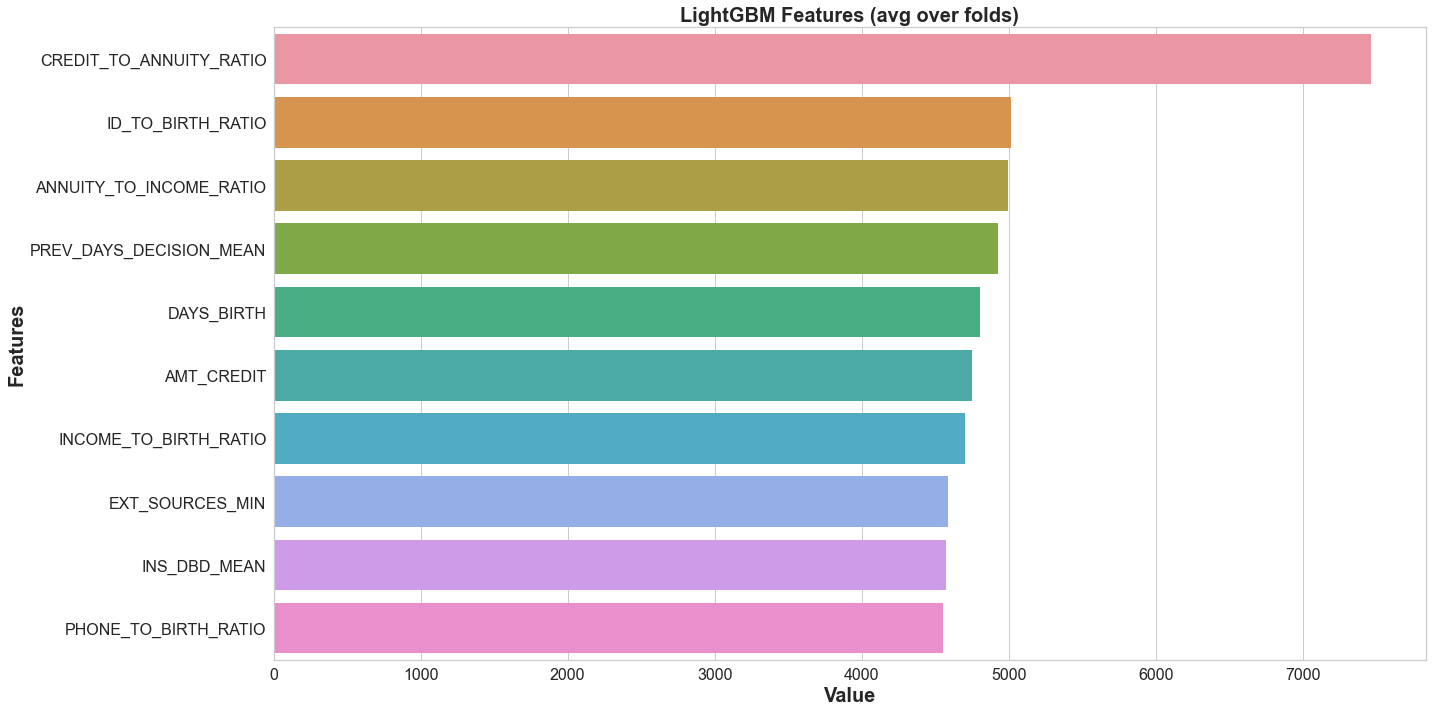

In [152]:
sorted(zip(best_model_bor_smote_w.feature_importances_, X_boruta.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(best_model_bor_smote_w.feature_importances_,X_train_boruta.columns)),
                           columns=['Value','Feature'])
data1=feature_imp.sort_values(by="Value", ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=data1.head(10))
plt.title('LightGBM Features (avg over folds)', weight='bold', size=20)
plt.yticks(fontsize=16)
plt.ylabel('Features', fontsize=20, weight='bold')
plt.xticks(fontsize=16)
plt.xlabel('Value', fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

### 6. Features importance via SHAP (SHapley Additive exPlanations)<a class="anchor" id="chapter6"></a>

Inspired by several methods on model interpretability, Lundberg and Lee (2016) proposed the SHAP value as a united approach to explaining the output of any machine learning model. Three benefits worth mentioning here.<br>

* The first one is global interpretability — the collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target.<br>

* The second benefit is local interpretability — each observation gets its own set of SHAP values. This greatly increases its transparency. We can explain why a case receives its prediction and the contributions of the predictors. Traditional variable importance algorithms only show the results across the entire population but not on each individual case. The local interpretability enables us to pinpoint and contrast the impacts of the factors.<br>

* Third, the SHAP values can be calculated for any tree-based model, while other methods use linear regression or logistic regression models as the surrogate models.

__Variable Importance Plot — Global Interpretability__

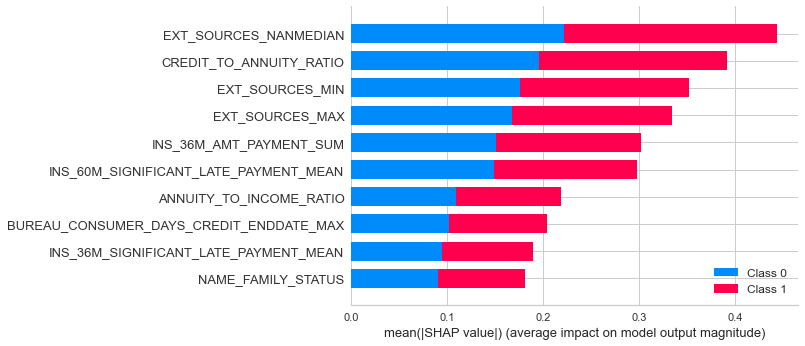

In [130]:
shap_values = shap.TreeExplainer(best_model_bor_smote_w).shap_values(X_valid_boruta)
shap.summary_plot(shap_values, X_valid_boruta, plot_type="bar", max_display=10)

A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.
The 3 most important features are:<br> 
EXT_SOURCES_NANMEDIAN<br>
CREDIT_TO_ANNUITY_RATIO<br>
EXT_SOURCES_MIN<br>

The SHAP value plot can further show the positive and negative relationships of the predictors with the target variable. 

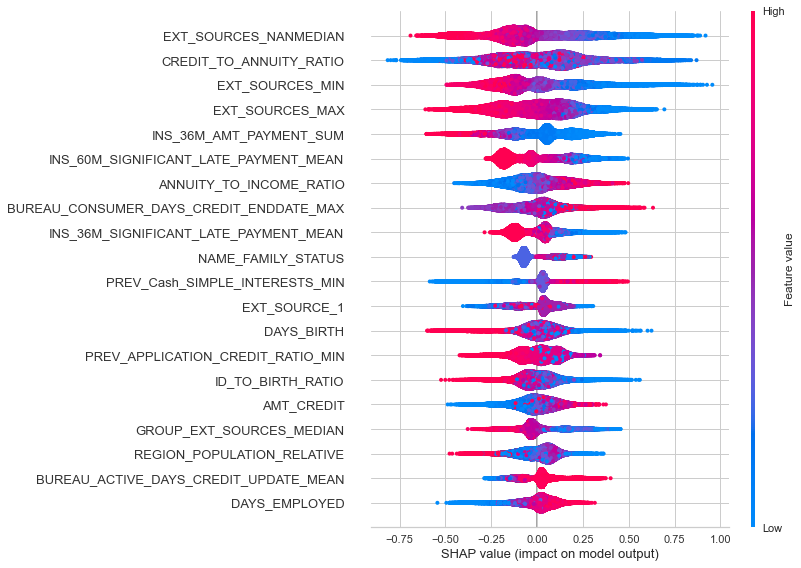

In [131]:
shap.summary_plot(shap_values[1], X_valid_boruta)

This plot is made of all the dots in the validation data. It demonstrates the following information:<br>

__Feature importance:__ Variables are ranked in descending order.<br>

__Impact:__ The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.<br>

__Original value:__ Color shows whether that variable is high (in red) or low (in blue) for that observation.<br>

In [132]:
# explainer = shap.Explainer(best_model_bor_smote_w, X_train_boruta)
# shap_values = explainer(X_train_boruta, check_additivity=False)

# joblib.dump(shap_values, "shap_values_train.pkl")

In [133]:
shap_values = joblib.load('shap_values_train.pkl')

 ### Individual SHAP Value Plot — Local Interpretability

Besides seeing the overall trend of feature impact, we can call the bar_plot or decision_plot methods to visualize how features contribute to individual predictions.

**Example of customer 100057**

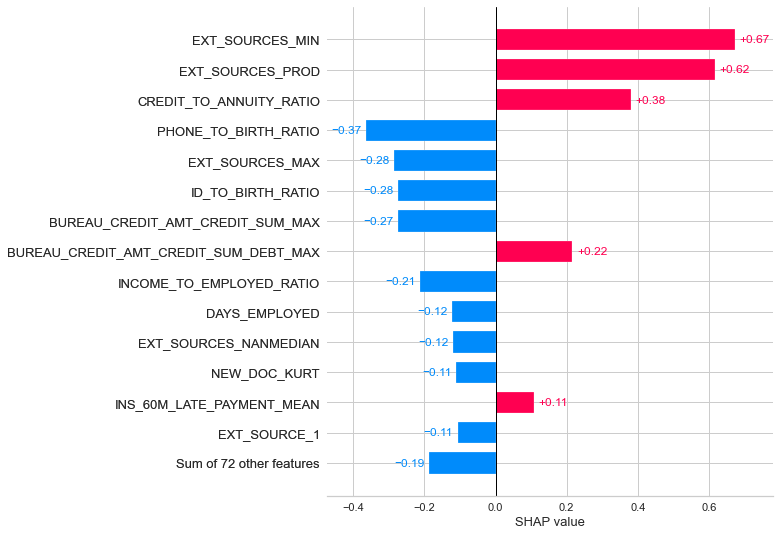

In [153]:
test_set = test_set_boruta.reset_index(drop=True)
customer_index = test_set[test_set['SK_ID_CURR'] == 100057].index.item()
X_set = test_set.set_index('SK_ID_CURR')
X_test_selected = X_set.iloc[customer_index]
shap.plots.bar(shap_values[customer_index], max_display=15)

### Saving best model & important features

In [135]:
data_test_ltd = data_test_boruta.head(2000)

In [136]:
pickle.dump(data_test_ltd, open('data_test_ltd.pkl', 'wb'))

In [137]:
feat_imp = feature_imp.sort_values(by='Value', ascending=False)

In [138]:
joblib.dump(feat_imp, 'feat_imp.pkl')

['feat_imp.pkl']

In [139]:
joblib.dump(best_model_bor_smote_w, 'final_model_w.pkl')

['final_model_w.pkl']

In [140]:
pickle.dump(best_model_bor_smote_w, open('bestmodel_w.pkl', 'wb'))

In [141]:
elapsed=datetime.now()- start_time
print(f'Running Time of notebook: {elapsed}')

Running Time of notebook: 1:53:11.399651
